In [1]:
# General
import os
import pandas as pd
import numpy as np
#from tqdm.notebook import tqdm
from tqdm import tqdm
import cv2

# Metrics
from sklearn.metrics import roc_auc_score

# Machine Learning Utilities
from sklearn.model_selection import train_test_split 

# Deep Learning
import torch
#import torchvision
import timm
from timm import create_model

import torch.nn as nn
#import torch.nn.functional as F
#import torch.optim as optim
#from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
#from torch.optim.lr_scheduler import CosineAnnealingLR
from fastai.vision.all import *
from fastai.vision.learner import _update_first_layer

# Image Augmentation
#import albumentations
#from albumentations.pytorch.transforms import ToTensorV2

In [2]:
# Device Type
# Device Optimization
if torch.cuda.is_available():
    device = 'gpu'  # torch.device('cuda')
else:
    device = 'cpu'  # torch.device('cpu')    
#print(f'Using device: {device}')
print(f'Using device: '+device)

Using device: gpu


Now, lets set a fixed random seed for repeatability.

In [3]:
set_seed(999,reproducible=True)

# Training Data
Now, lets load and inspect the training data's metadata CSV file.

In [4]:
data_dir = os.path.join('/','data')
df = pd.read_csv(os.path.join(data_dir,'train_labels.csv'))
df.head(3)

,id,target
0,00034abb3629,0
1,0004300a0b9b,0
2,000453852fda,0


Lets now add a column to detail the file path to the actual data file for each entry for the training set metadata and inspect the outcome.

In [5]:
train_data_dir = os.path.join('data', 'train')
df['path'] = df['id'].apply(lambda x: os.path.join('/')+train_data_dir+os.path.join('/')+f'{x[0]}/{x}.npy')
df.head(3)

,id,target,path
0,00034abb3629,0,/data/train/0/00034abb3629.npy
1,0004300a0b9b,0,/data/train/0/0004300a0b9b.npy
2,000453852fda,0,/data/train/0/000453852fda.npy


Lets now split the data frame with training data into subsets for training an validation. We'll use a fixed seed to do so in a repeatable manner.

In [6]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=999)

## Generate a Dataset for Pytorch
Lets now create an application-specific data class. The data class below enabled both channelized and spatial approaches along with the options to use only the three 'ON' channels or all six channels, including the 'OFF' channels. 

TODO: The data class may also be improved with some data augmentation routines to increase the datapoints available for training. 

For this notebook, we will train with the spatial approach that leverages all six channels.

In [7]:
class SETIDataset:
    def __init__(self, df, spatial=True, sixchan=True):
        self.df = df
        self.spatial = spatial  # Whether to use a spatial or channelized orrientation
        self.sixchan = sixchan  # Whether to use all six channels or just the three 'ON' channels
        
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        label = self.df.iloc[index].target
        filename = self.df.iloc[index].path
        data = np.load(filename).astype(np.float32)
        if not self.sixchan: data = data[::2].astype(np.float32)
        if self.spatial:
            data = np.vstack(data).transpose((1, 0))
            data = cv2.resize(data, dsize=(256,256))     
            data_tensor = torch.tensor(data).float().unsqueeze(0)
        else:
            data = np.transpose(data, (1,2,0))
            data = cv2.resize(data, dsize=(256,256))     
            data = np.transpose(data, (2, 0, 1)).astype(np.float32)
            data_tensor = torch.tensor(data).float()

        return (data_tensor, torch.tensor(label))

Lets take our previously created train and validation dataframes and use the `SETIDataset` class to generate data sets suitable for ingestion in a Pytorch model.

In [8]:
train_ds = SETIDataset(train_df)
valid_ds = SETIDataset(valid_df)

In [9]:
bs = 8 # batch size - range from 8 to 128+ depending on available VRAM on the GPU
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs, num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs, num_workers=8)

In [10]:
dls = DataLoaders(train_dl, valid_dl)

# Training
We will use Zachary Mueller's `timm_learner` function to create an already-instantiated `Learner` object with the `DataLoaders` and an appropriately defined CNN model taken from Ross Wightman's amazing `timm` package. The code for `timm_learner` (see the hidden cell below) is based on fastai's `cnn_learner` function. We can tell `timm_learner` what CNN backbone we want to use, as well as the number of input and output channels, and fastai automatically defines the appropriate model. We also pass in the metrics and the loss function. Fastai's default optimizer is AdamW. Finally, we can also use mixed precision training easily.

We'll use a simple ImageNet-pretrained ResNext50_32x4d model.

In [11]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_in=3, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, n_in=n_in, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [12]:
def roc_auc(preds,targ):
    try: return roc_auc_score(targ.cpu(),preds.squeeze().cpu())
    except: return 0.5

In [13]:
learn = timm_learner(dls,'resnext50_32x4d',pretrained=True,n_in=1,n_out=1,metrics=[roc_auc], opt_func=ranger, loss_func=BCEWithLogitsLossFlat()).to_fp16()

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


Next, lets employ a fastai function to solve for an optimal learning rate.

/usr/local/lib/python3.8/dist-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=tensor(0.0132))

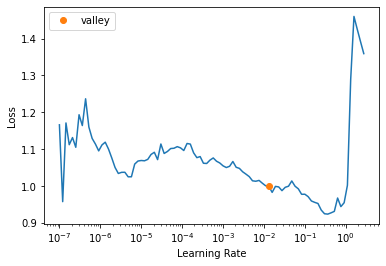

In [14]:
learn.lr_find()

The idea is that the learning rate where the loss decreases the most is likely the best learning rate. In this case, this is around ~3e-2.

Let's fine-tune the pretrained model using fastai's fit_one_cycle function to train the frozen pretrained model with a one-cycle learning rate schedule. I use high weight decay regularization to prevent overfitting.

In [15]:
learn.fit_one_cycle(3, 0.1, cbs=[ReduceLROnPlateau()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.558504,nan,0.619686,1:42:42
1,0.223693,nan,0.645264,1:42:30
2,0.112965,nan,0.575338,1:42:37


Epoch 0: reducing lr to 0.009698941938622575
Epoch 1: reducing lr to 0.0041331884829680565
Epoch 2: reducing lr to 1.001938284631021e-07


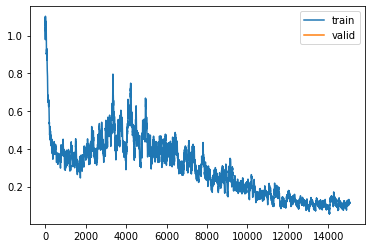

In [16]:
learn.recorder.plot_loss()

In [17]:
learn = learn.to_fp32()

Now lets save our model for use later.

In [18]:
learn.save('resnext50_32x4d-3epochs-8batch')
learn = learn.load('resnext50_32x4d-3epochs-8batch')

# Inference
Begin with the metadata file for the test data set and append file paths using the same methods applied to the training set.

In [21]:
data_dir = os.path.join('data')
test_df = pd.read_csv(os.path.join(os.path.join('/')+data_dir,'sample_submission.csv'))

test_dir = os.path.join('data', 'test')
test_df['path'] = test_df['id'].apply(lambda x: os.path.join('/')+test_dir+os.path.join('/')+f'{x[0]}/{x}.npy')
test_df.head(3)

,id,target,path
0,00034db451c4,0.5,/data/test/0/00034db451c4.npy
1,0006316b5ca0,0.5,/data/test/0/0006316b5ca0.npy
2,0006a953d21b,0.5,/data/test/0/0006a953d21b.npy


In [22]:
test_ds = SETIDataset(test_df)

In [23]:
bs = 8 # batch size - range from 8 to 128+ depending on available VRAM on the GPU
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=bs, num_workers=8, shuffle=False)

While fastai provides inference functions if we use their specific data API, in this case we used plain PyTorch dataloaders. So we'll just have to iterate over the dataloader and apply the model.

In [24]:
preds = []
for xb, _ in tqdm(test_dl):
    if device == 'gpu':
        with torch.no_grad(): output = learn.model(xb.cuda())
        preds.append(torch.sigmoid(output.float()).squeeze().cpu())
    elif device == 'cpu':
        with torch.no_grad(): output = learn.model(xb.cpu())
        preds.append(torch.sigmoid(output.float()).squeeze().cpu())
    else:
        print('device not recognized')
preds = torch.cat(preds)    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4481/4481 [27:32<00:00,  2.71it/s]


Finally, generate the CSV file detailing the predicted target class for each entry in the Test data set for submission to Kaggle.

In [25]:
sample_df = pd.read_csv(os.path.join('data','sample_submission.csv'))
sample_df['target'] = preds
sample_df.to_csv(os.path.join('data','submission_3epoch_8batch.csv'), index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'data/sample_submission.csv'